In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple
import os

from KC_DQN.DDQNPursuitEvasion import DDQNPursuitEvasion
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
toEnd = True
env_name = "dubins_car_pe-v0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
maxUpdates = 4000000
maxSteps = 100
updateTimes = 20
updatePeriod = int(maxUpdates / updateTimes)
updatePeriodHalf = int(updatePeriod/2)
small=False

modelsFolder = 'car/PE/easy'
figureFolder = 'figure/car/PE/easy'

os.makedirs(figureFolder, exist_ok=True)

In [3]:
#== Environment ==
if toEnd:
    env = gym.make(env_name, device=device, mode='RA', doneType='toEnd')
else:
    env = gym.make(env_name, device=device, mode='RA', doneType='TF')

stateNum = env.state.shape[0]
actionNum = env.action_space.n
action_list = np.arange(actionNum)
print("State Dimension: {:d}, ActionSpace Dimension: {:d}".format(stateNum, actionNum))

#== Setting in this Environment ==
env.set_radius_rotation(R_turn=.3)
env.set_capture_range(.1)
# env.set_bounds(np.array([[-2.2, 2.2],
#                          [-2.2, 2.2],
#                          [0, 2*np.pi]]))
env.set_constraint(radius=1, car='both')
env.set_target(radius=.5, car='evader')
print("Dynamic parameters:")
print("  EVADER")
print("    Constraint radius: {:.1f}, Target radius: {:.1f}, Turn radius: {:.2f}, Maximum speed: {:.1f}, Maximum angular speed: {:.3f}".format(
      env.evader.constraint_radius, env.evader.target_radius, env.evader.R_turn, env.evader.speed, env.evader.max_turning_rate))
print("  PURSUER")
print("    Constraint radius: {:.1f}, Turn radius: {:.2f}, Maximum speed: {:.1f}, Maximum angular speed: {:.3f}".format(
      env.pursuer.constraint_radius, env.pursuer.R_turn, env.pursuer.speed, env.pursuer.max_turning_rate))
print(env.evader.discrete_controls)
if 2*env.evader.R_turn-env.evader.constraint_radius > env.evader.target_radius:
    print("Type II Reach-Avoid Set")
else:
    print("Type I Reach-Avoid Set")

Env: mode---RA; doneType---toEnd
State Dimension: 6, ActionSpace Dimension: 9
Dynamic parameters:
  EVADER
    Constraint radius: 1.0, Target radius: 0.5, Turn radius: 0.30, Maximum speed: 0.5, Maximum angular speed: 1.667
  PURSUER
    Constraint radius: 1.0, Turn radius: 0.30, Maximum speed: 0.5, Maximum angular speed: 1.667
[-1.66666667  0.          1.66666667]
Type I Reach-Avoid Set


In [4]:
nx, ny = 101, 101
theta, xPursuer, yPursuer, thetaPursuer = 0., .1, .1, 0.
v = np.zeros((nx, ny))
l_x = np.zeros((nx, ny))
g_x = np.zeros((nx, ny))
xs = np.linspace(env.bounds[0,0], env.bounds[0,1], nx)
ys =np.linspace(env.bounds[1,0], env.bounds[1,1], ny)

it = np.nditer(l_x, flags=['multi_index'])

while not it.finished:
    idx = it.multi_index
    x = xs[idx[0]]
    y = ys[idx[1]]
    
    state = np.array([x, y, theta, xPursuer, yPursuer, thetaPursuer])
    l_x[idx] = env.target_margin(state)
    g_x[idx] = env.safety_margin(state)

    v[idx] = np.maximum(l_x[idx], g_x[idx])
    it.iternext()
    
print(np.max(g_x), np.min(g_x), np.max(l_x), np.min(l_x))

0.5556349186104046 -0.5175023316118512 1.0556349186104046 -0.5


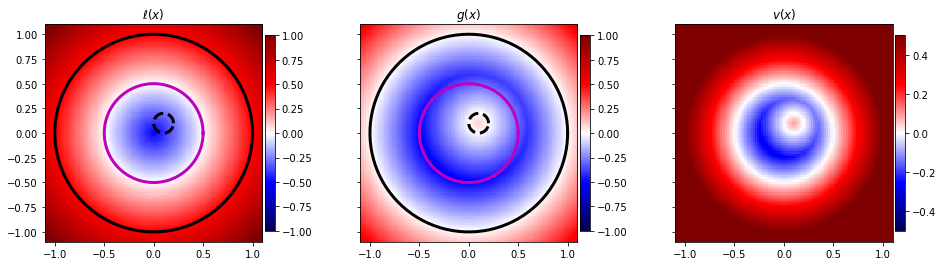

In [5]:
axStyle = env.get_axes()

fig, ax = plt.subplots(1, 3, figsize=(16,4), sharex=True, sharey=True)

f0 = ax[0].imshow(l_x.T, interpolation='none', extent=axStyle[0], origin="lower", cmap="seismic", vmin=-1, vmax=1)
ax[0].axis(axStyle[0])
ax[0].grid(False)
ax[0].set_aspect(axStyle[1])  # makes equal aspect ratio
env.plot_target_failure_set(ax[0], xPursuer=xPursuer, yPursuer=yPursuer)
ax[0].set_title(r'$\ell(x)$')
fig.colorbar(f0, ax=ax[0], pad=0.01, shrink=0.9)

f1 = ax[1].imshow(g_x, interpolation='none', extent=axStyle[0], origin="lower", cmap="seismic", vmin=-1, vmax=1)
ax[1].axis(axStyle[0])
ax[1].grid(False)
ax[1].set_aspect(axStyle[1])  # makes equal aspect ratio
ax[1].set_title(r'$g(x)$')
env.plot_target_failure_set(ax[1], xPursuer=xPursuer, yPursuer=yPursuer)
fig.colorbar(f1, ax=ax[1], pad=0.01, shrink=0.9)

f2 = ax[2].imshow(v.T, interpolation='none', extent=axStyle[0], origin="lower", cmap="seismic", vmin=-.5, vmax=.5)
ax[2].axis(axStyle[0])
ax[2].grid(False)
ax[2].set_aspect(axStyle[1])  # makes equal aspect ratio
# env.plot_target_failure_set(ax[2], xPursuer=xPursuer, yPursuer=yPursuer)
ax[2].set_title(r'$v(x)$')
fig.colorbar(f2, ax=ax[2], pad=0.01, shrink=0.9)

## DDQN

{'MAX_UPDATES': 4000000, 'MAX_EP_STEPS': 100, 'EPSILON': 0.95, 'EPS_END': 0.05, 'EPS_PERIOD': 200000, 'EPS_DECAY': 0.6, 'LR_C': 0.001, 'LR_C_END': 0.0001, 'LR_C_PERIOD': 200000, 'LR_C_DECAY': 0.8, 'GAMMA': 0.8, 'GAMMA_END': 0.999999, 'GAMMA_PERIOD': 200000, 'GAMMA_DECAY': 0.5, 'MEMORY_CAPACITY': 10000, 'BATCH_SIZE': 100, 'TAU': 0.01, 'HARD_UPDATE': 1, 'SOFT_UPDATE': True, 'RENDER': False, 'ENV_NAME': 'dubins_car_pe-v0', 'MAX_MODEL': 50, 'DEVICE': device(type='cpu'), 'DOUBLE': True}


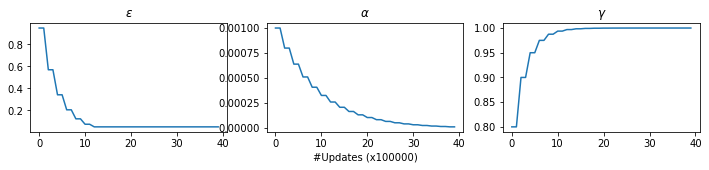

0.9999996185302734 1.4411518807585605e-05


In [6]:
#== REPORT ==
CONFIG = dqnConfig(DEVICE=device, ENV_NAME=env_name, 
                   MAX_UPDATES=maxUpdates, MAX_EP_STEPS=maxSteps,
                   BATCH_SIZE=100, MEMORY_CAPACITY=10000,
                   GAMMA=.8, GAMMA_PERIOD=updatePeriod, GAMMA_END=0.999999,
                   EPS_PERIOD=updatePeriod, EPS_DECAY=0.6,
                   LR_C=1e-3, LR_C_PERIOD=updatePeriod, LR_C_DECAY=0.8,
                   MAX_MODEL=50)
print(vars(CONFIG))

#== FIGURE ==
fig, ax = plt.subplots(1, 3, figsize=(12,2), sharex=True)
base = updatePeriodHalf
numUpdates = int(maxUpdates/base)

eps = np.zeros(numUpdates)
lr = np.zeros(numUpdates)
gamma = np.zeros(numUpdates)
eps_tmp = CONFIG.EPSILON
lr_tmp = CONFIG.LR_C
gamma_tmp = CONFIG.GAMMA
for i in range(numUpdates):
    if i != 0 and i % int(CONFIG.EPS_PERIOD/base) == 0:
        eps_tmp = max(eps_tmp*CONFIG.EPS_DECAY, 0.05)
    if i != 0 and i % int(CONFIG.LR_C_PERIOD/base) == 0:
        lr_tmp = max(lr_tmp*CONFIG.LR_C_DECAY, 1e-5)
    if i != 0 and i % int(CONFIG.GAMMA_PERIOD/base) == 0:
        gamma_tmp = min(1-(1-gamma_tmp)*CONFIG.GAMMA_DECAY, 0.99999999)
    eps[i] = eps_tmp
    lr[i] = lr_tmp
    gamma[i] = gamma_tmp
ax[0].plot(np.arange(numUpdates), eps)
ax[1].plot(np.arange(numUpdates), lr)
ax[2].plot(np.arange(numUpdates), gamma)
ax[0].set_title(r'$\epsilon$')
ax[1].set_title(r'$\alpha$')
ax[2].set_title(r'$\gamma$')
ax[1].set_xlabel('#Updates (x{:d})'.format(base))
plt.show()

print(gamma[-1], lr[-1])

In [7]:
#== AGENT ==
numActionList = env.numActionList
numJoinAction = int(numActionList[0] * numActionList[1])
dimList = [stateNum, 200, 200, actionNum]

agent = DDQNPursuitEvasion(CONFIG, numActionList, dimList, actType='Tanh')


ModuleList(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=9, bias=True)
)


200000
Warmup Buffer [10000] --- Warmup Buffer Ends
Warmup Q [20000] --- Warmup Q Ends
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


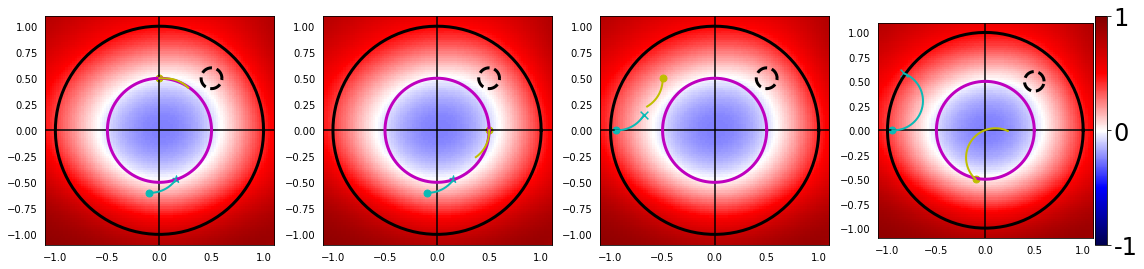

3354: This episode gets running/episode cost = (22.22/32.00) after 32 steps. The agent currently updates 199974 times				
After [200000] updates:
  - eps=0.57, gamma=0.900000, lr=8.0e-04.
  - success/failure/unfinished ratio: 0.350, 0.650, 0.000
=> Save models/car/PE/easy/model-200000.pth after [200000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


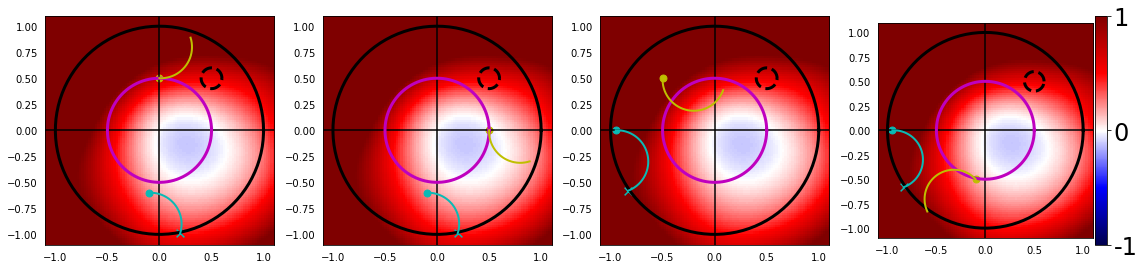

6752: This episode gets running/episode cost = (14.92/5.00) after 34 steps. The agent currently updates 399994 times					
After [400000] updates:
  - eps=0.34, gamma=0.950000, lr=6.4e-04.
  - success/failure/unfinished ratio: 0.350, 0.650, 0.000
=> Save models/car/PE/easy/model-400000.pth after [400000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


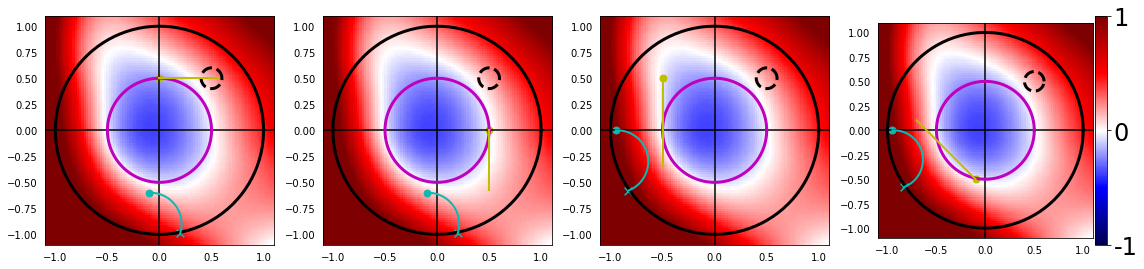

10136: This episode gets running/episode cost = (21.90/30.00) after 63 steps. The agent currently updates 599947 times				
After [600000] updates:
  - eps=0.21, gamma=0.975000, lr=5.1e-04.
  - success/failure/unfinished ratio: 0.315, 0.685, 0.000
=> Save models/car/PE/easy/model-600000.pth after [600000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


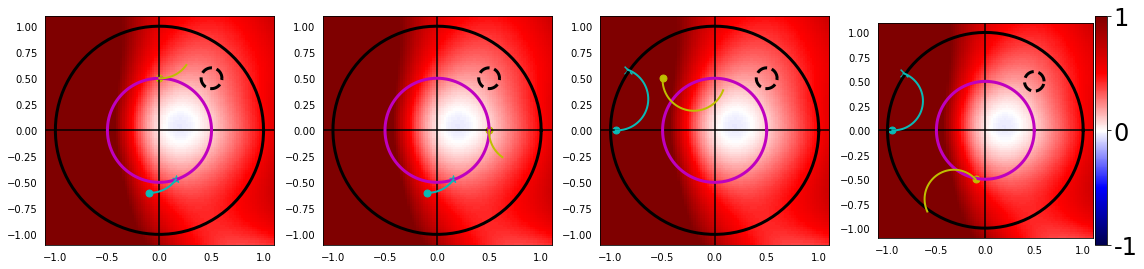

13507: This episode gets running/episode cost = (10.74/-26.00) after 99 steps. The agent currently updates 799919 times			
After [800000] updates:
  - eps=0.12, gamma=0.987500, lr=4.1e-04.
  - success/failure/unfinished ratio: 0.285, 0.715, 0.000
=> Save models/car/PE/easy/model-800000.pth after [800000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


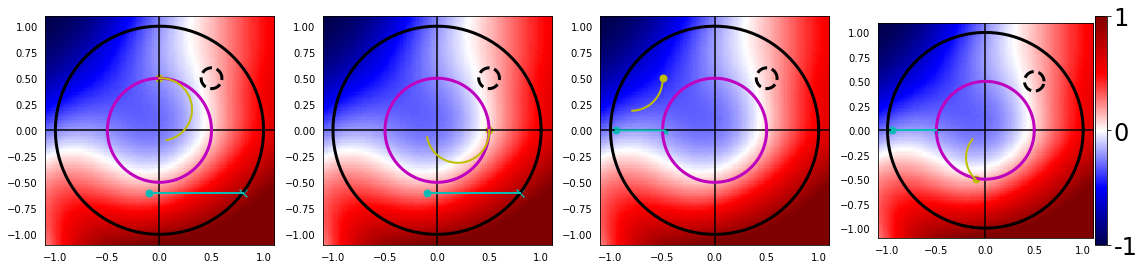

16385: This episode gets running/episode cost = (17.38/68.00) after 100 steps. The agent currently updates 999954 times			
After [1000000] updates:
  - eps=0.07, gamma=0.993750, lr=3.3e-04.
  - success/failure/unfinished ratio: 0.300, 0.700, 0.000
=> Save models/car/PE/easy/model-1000000.pth after [1000000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


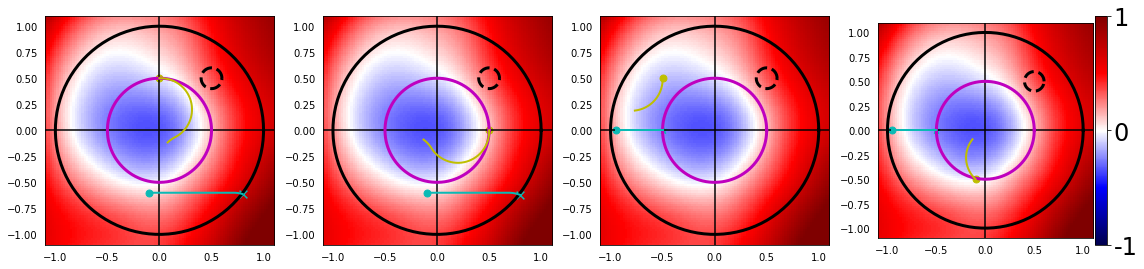

18943: This episode gets running/episode cost = (15.51/-51.00) after 100 steps. The agent currently updates 1199940 times		
After [1200000] updates:
  - eps=0.05, gamma=0.996875, lr=2.6e-04.
  - success/failure/unfinished ratio: 0.380, 0.620, 0.000
=> Save models/car/PE/easy/model-1200000.pth after [1200000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


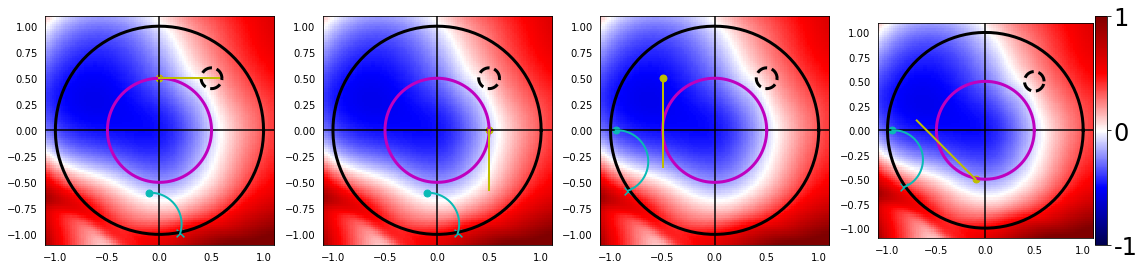

21437: This episode gets running/episode cost = (22.73/35.00) after 35 steps. The agent currently updates 1399921 times					
After [1400000] updates:
  - eps=0.05, gamma=0.998437, lr=2.1e-04.
  - success/failure/unfinished ratio: 0.320, 0.675, 0.005
=> Save models/car/PE/easy/model-1400000.pth after [1400000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


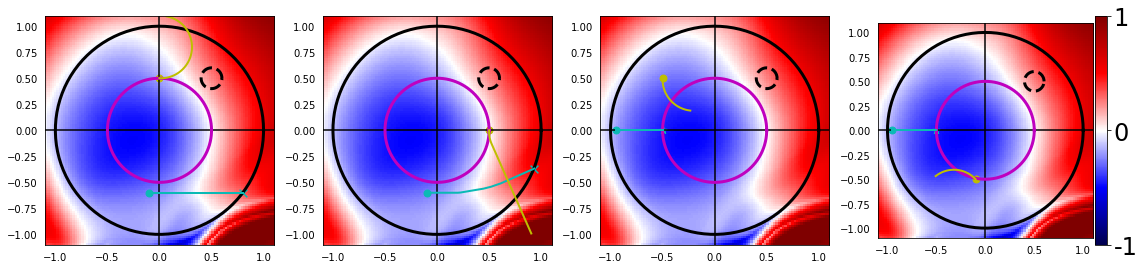

23889: This episode gets running/episode cost = (15.07/-3.00) after 44 steps. The agent currently updates 1599995 times					
After [1600000] updates:
  - eps=0.05, gamma=0.999219, lr=1.7e-04.
  - success/failure/unfinished ratio: 0.270, 0.730, 0.000
=> Save models/car/PE/easy/model-1600000.pth after [1600000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


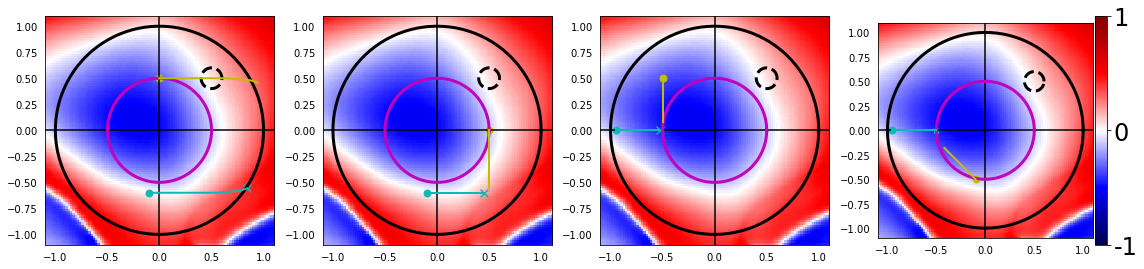

26335: This episode gets running/episode cost = (17.52/8.00) after 18 steps. The agent currently updates 1799985 times						
After [1800000] updates:
  - eps=0.05, gamma=0.999609, lr=1.3e-04.
  - success/failure/unfinished ratio: 0.275, 0.725, 0.000
=> Save models/car/PE/easy/model-1800000.pth after [1800000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


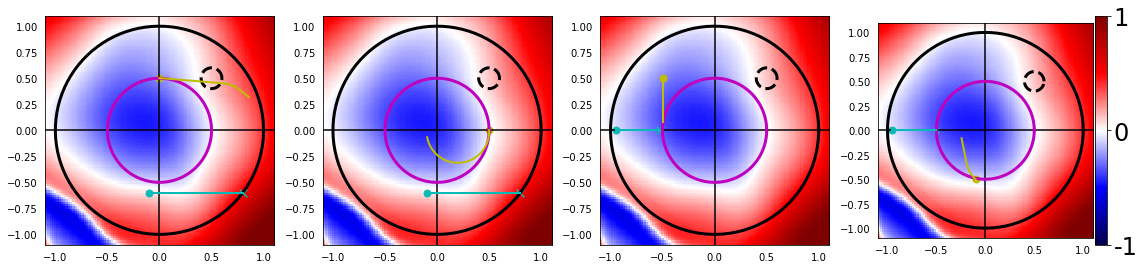

28758: This episode gets running/episode cost = (16.06/-66.00) after 100 steps. The agent currently updates 1999968 times			
After [2000000] updates:
  - eps=0.05, gamma=0.999805, lr=1.1e-04.
  - success/failure/unfinished ratio: 0.335, 0.665, 0.000
=> Save models/car/PE/easy/model-2000000.pth after [2000000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


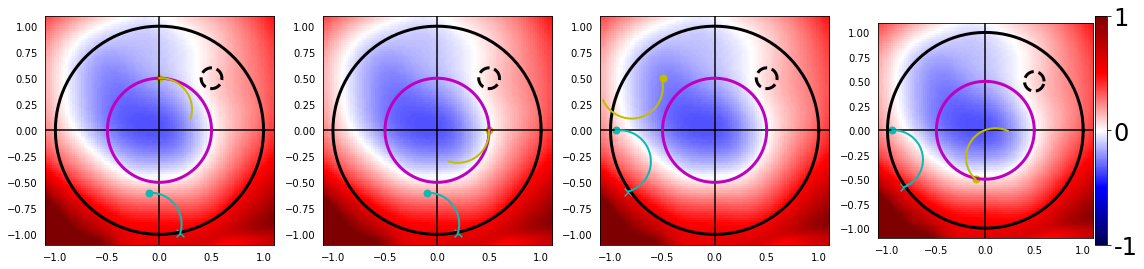

31158: This episode gets running/episode cost = (16.27/8.00) after 100 steps. The agent currently updates 2199901 times						
After [2200000] updates:
  - eps=0.05, gamma=0.999902, lr=8.6e-05.
  - success/failure/unfinished ratio: 0.305, 0.695, 0.000
=> Save models/car/PE/easy/model-2200000.pth after [2200000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


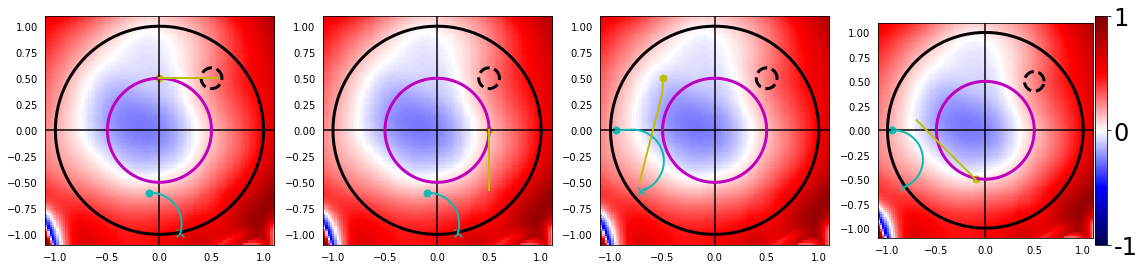

33588: This episode gets running/episode cost = (2.62/24.00) after 100 steps. The agent currently updates 2399995 times					
After [2400000] updates:
  - eps=0.05, gamma=0.999951, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.415, 0.585, 0.000
=> Save models/car/PE/easy/model-2400000.pth after [2400000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


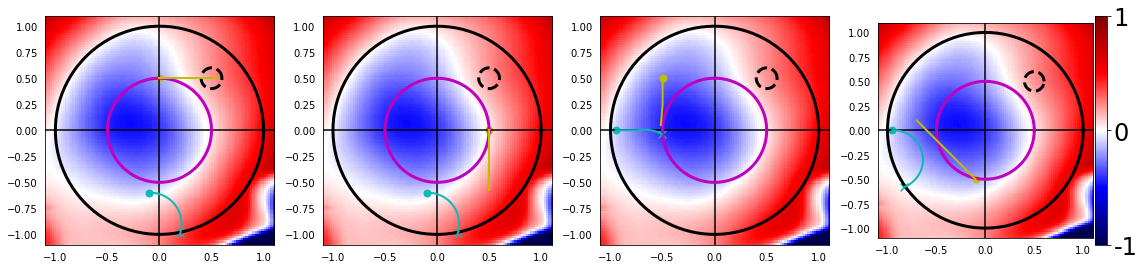

35963: This episode gets running/episode cost = (21.48/92.00) after 100 steps. The agent currently updates 2599948 times				
After [2600000] updates:
  - eps=0.05, gamma=0.999976, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.365, 0.635, 0.000
=> Save models/car/PE/easy/model-2600000.pth after [2600000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


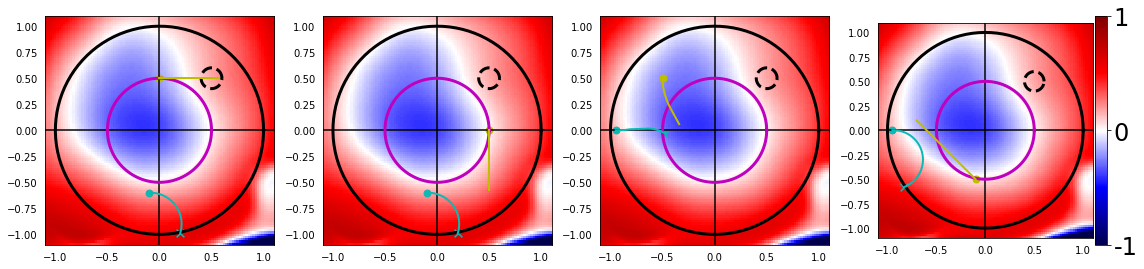

38375: This episode gets running/episode cost = (3.57/6.00) after 18 steps. The agent currently updates 2799990 times		s					The agent currently updates 2646094 times		
After [2800000] updates:
  - eps=0.05, gamma=0.999988, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.300, 0.565, 0.135
=> Save models/car/PE/easy/model-2800000.pth after [2800000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


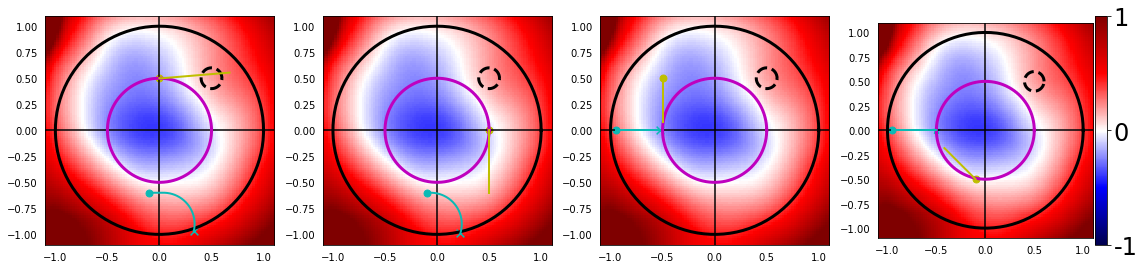

40812: This episode gets running/episode cost = (3.62/47.00) after 47 steps. The agent currently updates 2999949 times						
After [3000000] updates:
  - eps=0.05, gamma=0.999994, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.370, 0.630, 0.000
=> Save models/car/PE/easy/model-3000000.pth after [3000000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


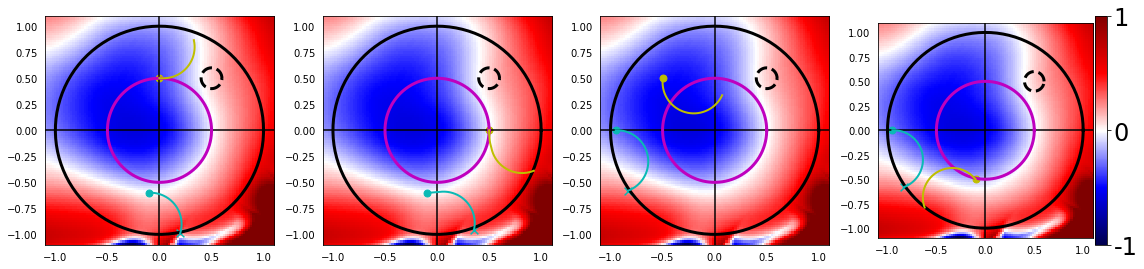

43219: This episode gets running/episode cost = (-9.89/-42.00) after 100 steps. The agent currently updates 3199979 times				
After [3200000] updates:
  - eps=0.05, gamma=0.999997, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.350, 0.650, 0.000
=> Save models/car/PE/easy/model-3200000.pth after [3200000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


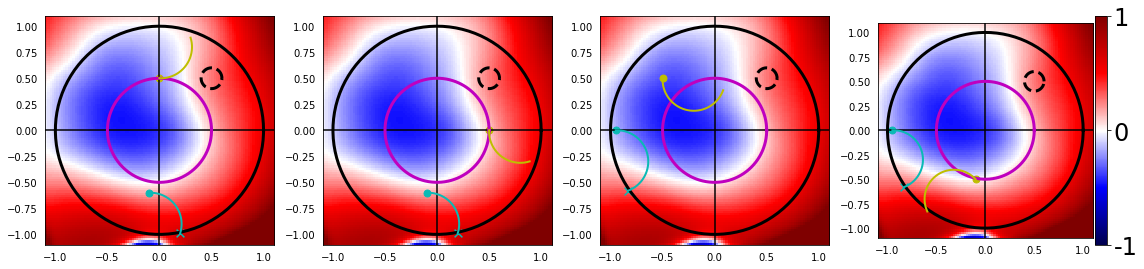

45664: This episode gets running/episode cost = (15.71/72.00) after 100 steps. The agent currently updates 3399906 times				
After [3400000] updates:
  - eps=0.05, gamma=0.999998, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.335, 0.655, 0.010
=> Save models/car/PE/easy/model-3400000.pth after [3400000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


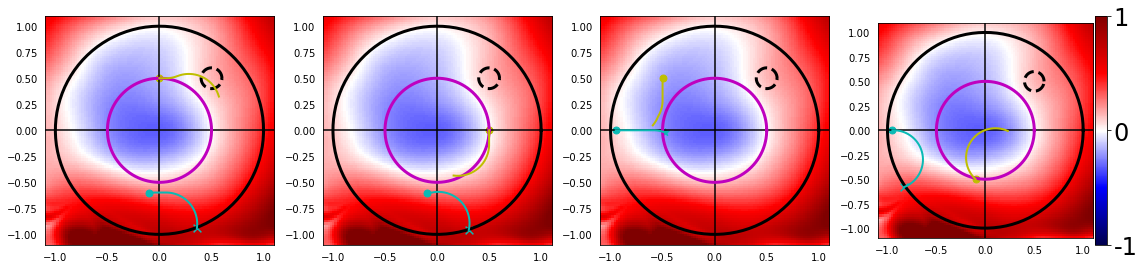

48043: This episode gets running/episode cost = (2.41/3.00) after 100 steps. The agent currently updates 3599920 times							The agent currently updates 3417355 times		
After [3600000] updates:
  - eps=0.05, gamma=0.999999, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.395, 0.580, 0.025
=> Save models/car/PE/easy/model-3600000.pth after [3600000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


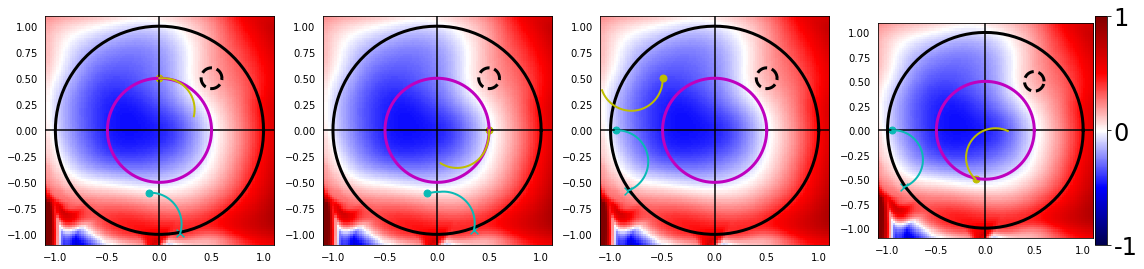

50477: This episode gets running/episode cost = (12.62/33.00) after 100 steps. The agent currently updates 3799986 times				
After [3800000] updates:
  - eps=0.05, gamma=0.999999, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.345, 0.655, 0.000
=> Save models/car/PE/easy/model-3800000.pth after [3800000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


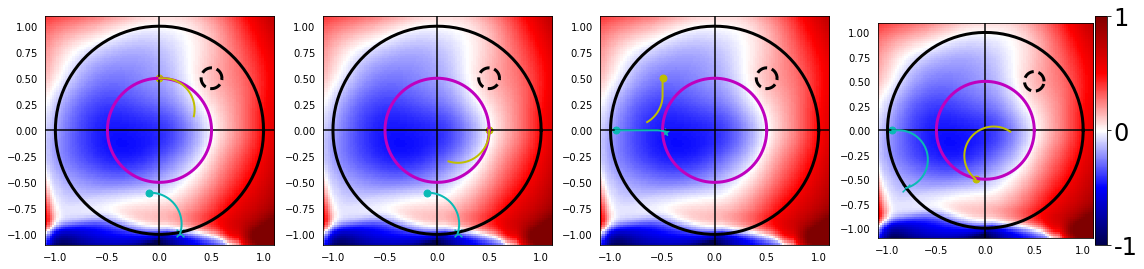

52880: This episode gets running/episode cost = (-4.03/8.00) after 34 steps. The agent currently updates 3999997 times		s			
After [4000000] updates:
  - eps=0.05, gamma=0.999999, lr=1.0e-04.
  - success/failure/unfinished ratio: 0.235, 0.765, 0.000
=> Save models/car/PE/easy/model-4000000.pth after [4000000] updates
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)


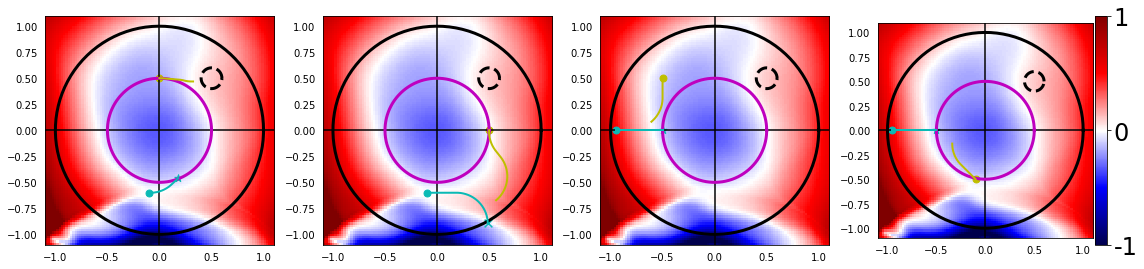

52881: This episode gets running/episode cost = (-3.03/6.00) after 79 steps. The agent currently updates 4000076 times		
=> Save models/car/PE/easy/model-4000076.pth after [4000076] updates


In [8]:
#== AGENT ==
vmin = -1
vmax = 1
checkPeriod = updatePeriod
print(checkPeriod)
training_records, trainProgress = agent.learn(env, MAX_UPDATES=maxUpdates, MAX_EP_STEPS=CONFIG.MAX_EP_STEPS, addBias=False,
                                              warmupQ=True, warmupIter=20000, doneTerminate=True,
                                              vmin=vmin, vmax=vmax, showBool=False,
                                              checkPeriod=checkPeriod, outFolder=modelsFolder)

Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.1, 0.1, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.3, 0.3, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.5, 0.5, 0.0)
Getting values with evader's theta and pursuer's (x, y, theta) equal to 0.0 and (0.7, 0.7, 0.0)


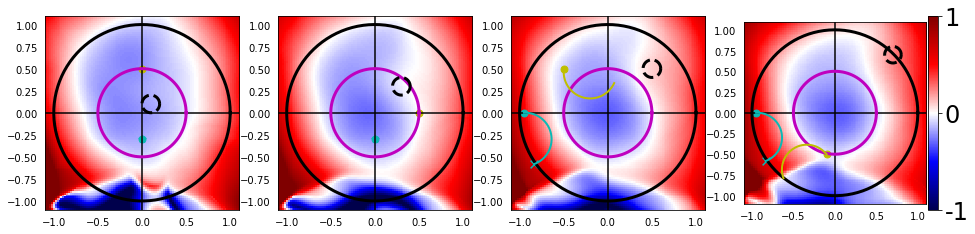

In [9]:
fig, axes = plt.subplots(1,4, figsize=(16, 4))

evader_initial_states =[ np.array([0., -env.R_turn, 0.]),
                         np.array([ -0.95*env.evader_constraint_radius, 0., 0.]) ]

pursuer_initial_states = [ np.array([ 0., .5, 0.]),
                           np.array([ .5,  0, 1.5*np.pi]),
                           np.array([ -.5, .5, 1.5*np.pi]),
                           np.array([ -.1, -.5, .75*np.pi]) ]

states = []
for i, stateEvader in enumerate(evader_initial_states):
    for j in range(2):
        statePursuer = pursuer_initial_states[2*i+j]
        states.append(np.concatenate((stateEvader, statePursuer), axis=0))

xPursuerList=[.1, .3, .5, .7]
yPursuerList=[.1, .3, .5, .7]
for i, (state, ax, xPursuer, yPursuer) in enumerate(zip(states, axes, xPursuerList, yPursuerList)):
    print("{:d}/{:d}".format(i, 4), end='\r')
    state=[state]
    cbarPlot = i==3
    env.plot_formatting(ax=ax)
    env.plot_target_failure_set(ax=ax, xPursuer=xPursuer, yPursuer=yPursuer)
    env.plot_trajectories(agent.Q_network, T=100, num_rnd_traj=1, states=state, theta=None,
                          keepOutOf=True, toEnd=False, ax=ax)
    env.plot_v_values(agent.Q_network, ax=ax, fig=fig, cbarPlot=cbarPlot,
                      xPursuer=xPursuer, yPursuer=yPursuer, cmap='seismic', vmin=-1, vmax=1)